In [8]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [10]:
output_dir_4_5_5 ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.5_linear_scale-up_etc/ciff_sam/2021_11_23_17_59_09/count_data/'
output_dir_4_5_6 ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.6_no_x_factor/ciff_sam/2021_11_29_14_01_14/count_data/'

In [16]:
pd.read_csv(output_dir_4_5_5 + 'wasting_transition_count.csv').age.unique()

array(['early_neonatal', 'late_neonatal', '1-5_months', '6-11_months',
       '12_to_23_months', '2_to_4'], dtype=object)

In [12]:
def calculate_wasting_prevalence(output_dir, ages, strata_cols, prevalence, percent_reduction):
    if prevalence==True:
        data = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        wasted = data.loc[data.cause.str.contains('acute_malnutrition')]
    elif prevalence==False:
        data = (pd.read_csv(output_dir + 'wasting_transition_count.csv')
                .drop(columns=['Unnamed: 0']).rename(columns={'measure':'cause'}))
        wasted = data.loc[data.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                                          'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count'])]
        pt = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
    groupby_cols = ['input_draw','scenario','cause']
    wasted = (wasted.groupby([c for c in wasted.columns if c != 'cause' and c != 'value']).sum())
    wasted['cause'] = 'wasted'
    data = pd.concat([data,wasted.reset_index()],ignore_index=True)
    data = data.loc[data.age.isin(ages)]
    data = data.groupby(['input_draw','scenario'] + strata_cols + ['cause']).sum()
    if prevalence==True:
        data = data / data.groupby(['input_draw','scenario'] + strata_cols).sum() * 100
    else:
        pt = pt.loc[pt.age.isin(ages)].groupby(['input_draw','scenario'] + strata_cols).sum()
        data = data / pt * 100_000
    if percent_reduction==False:
        data = (data.groupby(['scenario','cause'] + strata_cols)
                    .describe(percentiles=[0.025,0.975]))
    else:
        data_baseline = (data.reset_index().loc[data.reset_index().scenario=='baseline']
                   .set_index(['input_draw','cause'] + strata_cols)
                   .drop(columns='scenario'))
        data = ((data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario']))
                / data_baseline) * 100
        data = (data.reset_index().groupby(['scenario','cause'] + strata_cols)
                .describe(percentiles=[0.025,0.975])).drop(columns='input_draw')
    return data[['value']].reset_index()

In [17]:
six_to_59_ages = ['6-11_months',
       '12_to_23_months', '2_to_4']

In [18]:
calculate_wasting_prevalence(output_dir_4_5_6, six_to_59_ages, ['year'], 
                                 prevalence=True, percent_reduction=True)
calculate_wasting_prevalence(output_dir_4_5_5, six_to_59_ages, ['year'], 
                                 prevalence=True, percent_reduction=True).head()

scenario               cause  year value                                 \
                                      count mean  std  min 2.5%  50% 97.5%   
0  baseline  mild_child_wasting  2022  12.0  0.0  0.0  0.0  0.0  0.0   0.0   
1  baseline  mild_child_wasting  2023  12.0  0.0  0.0  0.0  0.0  0.0   0.0   
2  baseline  mild_child_wasting  2024  12.0  0.0  0.0  0.0  0.0  0.0   0.0   
3  baseline  mild_child_wasting  2025  12.0  0.0  0.0  0.0  0.0  0.0   0.0   
4  baseline  mild_child_wasting  2026  12.0  0.0  0.0  0.0  0.0  0.0   0.0   

        
   max  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

Text(1.5, 3.3, 'Wasting exposure for each wasted state and scenario, by x-factor inclusion')

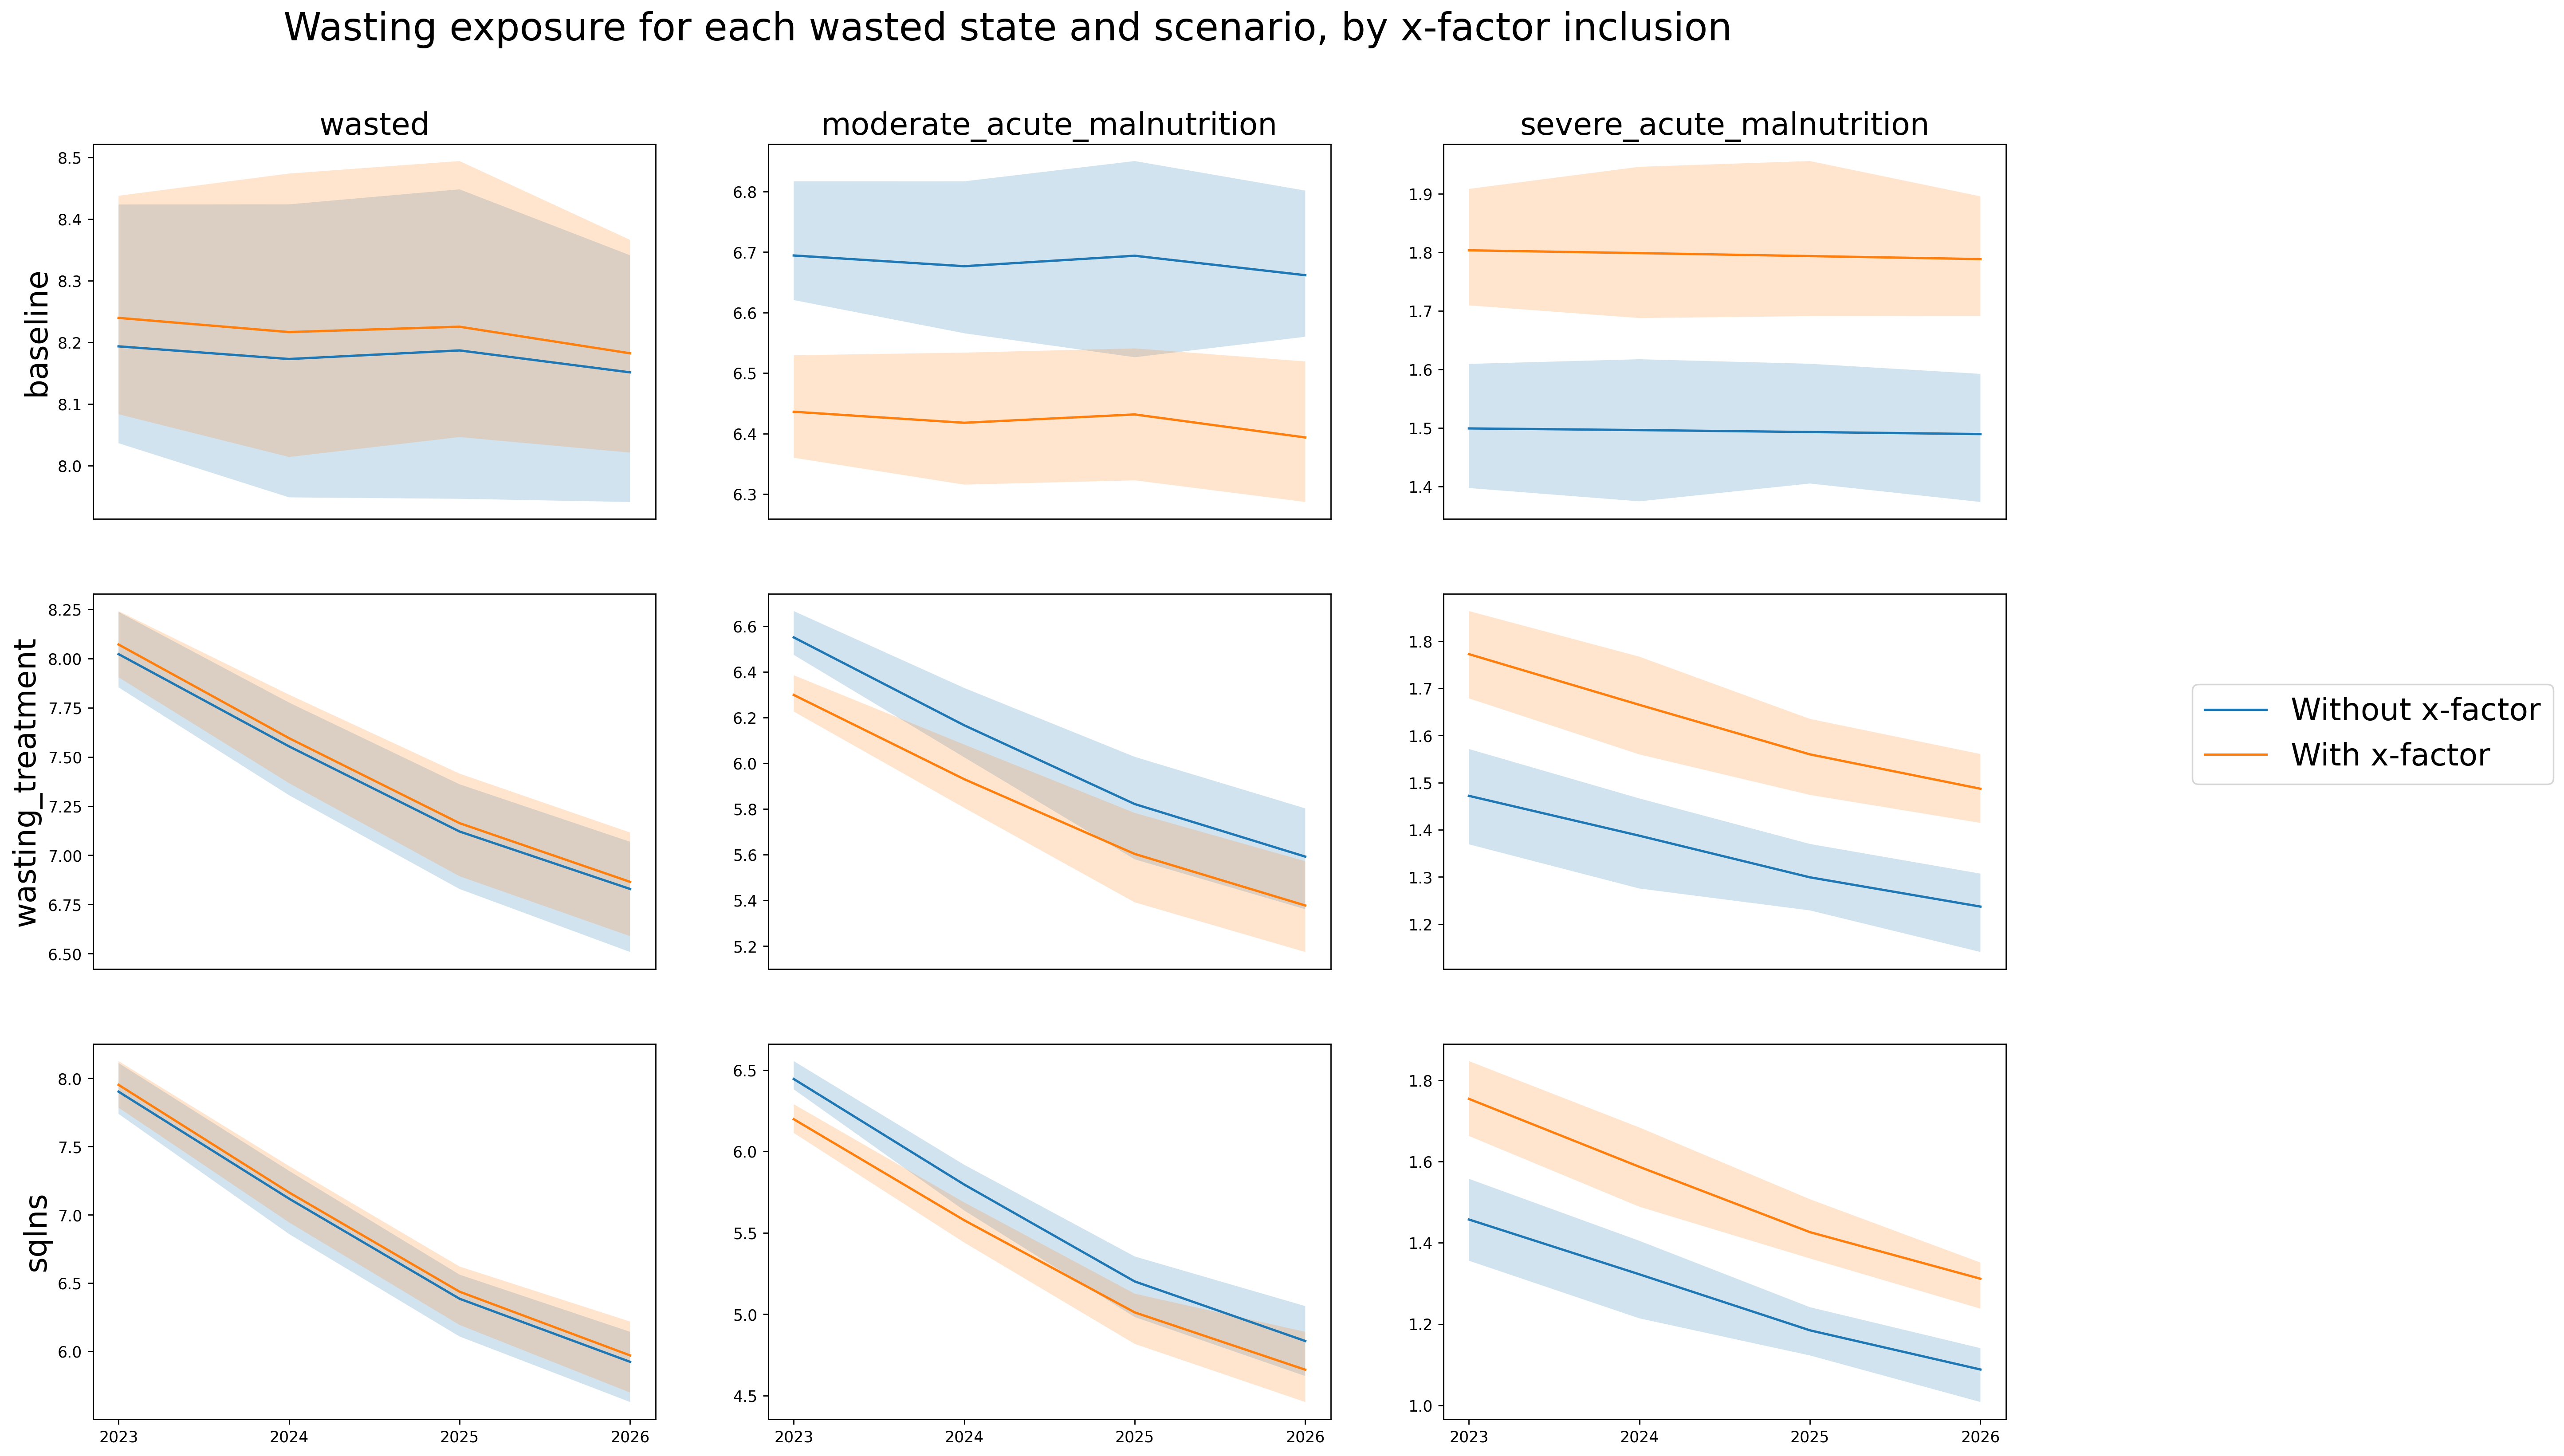

In [31]:
causes = ['wasted','moderate_acute_malnutrition','severe_acute_malnutrition']
scenarios = ['baseline','wasting_treatment','sqlns']

fig, axs = plt.subplots(3, 3,dpi=250)
for cause in causes:
    for scenario in scenarios:
        for output_dir in [output_dir_4_5_6, output_dir_4_5_5]:
            data = calculate_wasting_prevalence(output_dir, six_to_59_ages, ['year'], 
                                             prevalence=True, percent_reduction=False)
            p = data.loc[(data.cause==cause)&(data.scenario==scenario)&(data.year>2022)]
            pos = axs[scenarios.index(scenario),causes.index(cause)]   
            pos.plot(p.year, p['value','mean'])
            pos.fill_between(p.year, p['value','2.5%'], p['value','97.5%'],alpha=0.2)
            #pos.set_ylim(0,10)
            if scenarios.index(scenario)==0:
                pos.set_title(cause, size=20)
            if causes.index(cause)==0:
                pos.set_ylabel(scenario, size=20)
            if scenarios.index(scenario)==2:
                pos.set_xticks(p.year)
            else:
                pos.set_xticks([])
                
plt.subplots_adjust(right=3, top=3)
plt.legend(['Without x-factor','With x-factor'], bbox_to_anchor=[2,2], fontsize=20)
plt.suptitle('Wasting exposure for each wasted state and scenario, by x-factor inclusion',
             y=3.3,x=1.5,size=25)

In [197]:
def plot_exposure_by_year(output_dir, ages, strata_cols, cause, title, 
                          prevalence=True, percent_reduction=False, legend=True):
    plt.figure(dpi=120)
    data = calculate_wasting_prevalence(output_dir, six_to_59_ages, ['year'], 
                                 prevalence, percent_reduction)
    p = data.loc[data.cause==cause]
    for i in ['baseline','wasting_treatment','sqlns']:
        p_sub = p.loc[p.scenario==i]
        plt.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=i)
        plt.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=0.2)
    if legend==True:
        plt.legend(['Baseline',
                'Wasting treatment scale-up',
                'SQ-LNS and wasting treatment scale-up'],
              fontsize=13)
    plt.xticks(p.year.unique(),size=14)
    plt.yticks(size=14)
    if percent_reduction==True:
        plt.ylabel('Percent reduction\nrelative to baseline',size=14)
    elif prevalence==True:
        plt.ylabel('Percent exposed',size=14)
    else:
        plt.ylabel('Annual cumulative incidence\nper 100,000 person-years',size=14)
    plt.ylim(0,p['value','97.5%'].max()*1.1)
    plt.grid()
    plt.title(title, size=18)

In [198]:
six_to_59_ages = ['6-11_months',
       '12_to_23_months', '2_to_4']

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


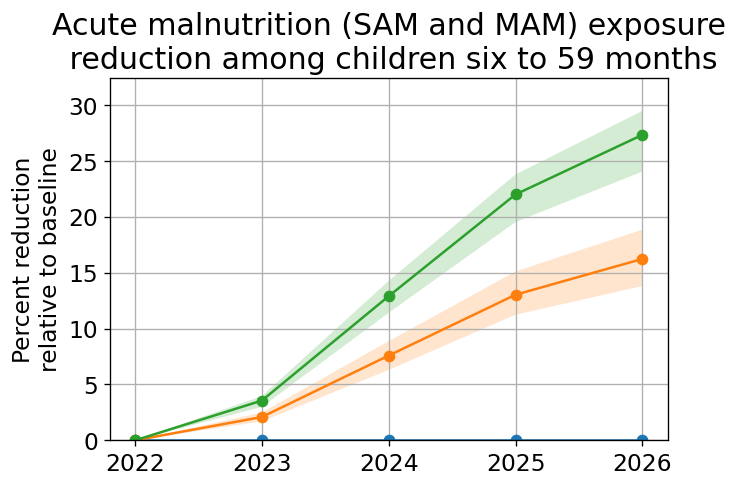

In [203]:
plot_exposure_by_year(output_dir_4_5_6, six_to_59_ages, ['year'],
    'wasted',
    'Acute malnutrition (SAM and MAM) exposure\n reduction among children six to 59 months',
                                 prevalence=True, percent_reduction=True, legend=False)